# Przykładowy model - tensorflow & keras

Przykładowy model do odszumiania sygnałów sinusoidalnych inspirowany siecią DeconvNet: https://arxiv.org/abs/1505.04366

Wektor `X` o wymiarach `(liczba_przykładów, długość_sygnału, liczba_kanałów)` zawiera zaszumiony przebieg sinusoidalny. W tensorze `Y` o tych samych wymiarach znajduje się idealnie odszumiony wynik. Sieć uczona jest na podstawie tensora `X` znajdować wektor `Y`. W kodzie zwykle wynik odszumiania nazywany jest `Y_pred`. Liczba kanałów w przygotowanym przykładzie zawsze równa się 1.

## Przygotowanie danych treningowych i walidacyjnych

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N= 1000
x= np.linspace(0,2.*np.pi,128)
x= x[np.newaxis,:]
x= np.repeat(x, repeats=N, axis=0)

amplitudes= np.random.random(size=(N,1))
periods= np.random.random(size=(N,1))
Y= amplitudes*np.sin(2*np.pi/(2*periods+2)*x)

# Add noise
X= Y + np.random.normal(loc=0.0, scale=0.05, size=Y.shape)

#### Przykładowe dane

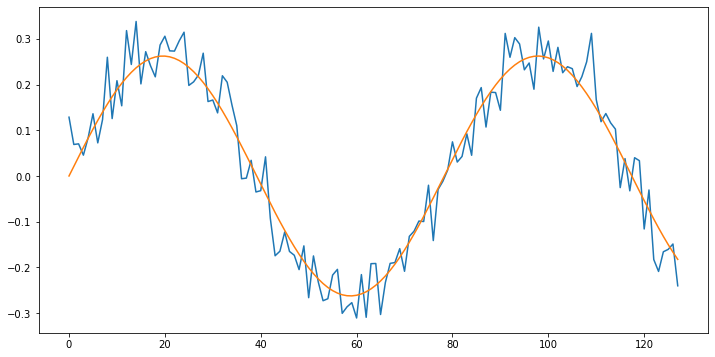

In [3]:
i= 5
plt.figure(figsize=(12,6))
plt.plot(X[i])
plt.plot(Y[i])
plt.show()

### Podział danych na treningowe i walidacyjne

In [4]:
split_idx= int(N*0.8)

X_train= X[:split_idx]
X_val= X[split_idx:]
Y_train= Y[:split_idx]
Y_val= Y[split_idx:]

## Tworzenie modelu

In [5]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam

In [6]:
def create_model(input_shape= (128,1)):
    input_vec = Input(shape=input_shape)

    x = Conv1D(4, 3, activation='relu', padding='same')(input_vec)
    x = Conv1D(4, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(4, 3, activation='relu', padding='same')(x)
    x = Conv1D(4, 3, activation='relu', padding='same')(x)

    decoded = Conv1D(1, 3, activation='linear', padding='same')(x)

    return Model(input_vec, decoded)

model= create_model(input_shape= (None,1))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=nadam)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 4)           16        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 4)           52        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 4)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 8)           104       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 8)           200       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 8)           0     

### Uczenie modelu

In [7]:
history = model.fit(X_train, Y_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val, Y_val))

Epoch 1/100
7/7 [==============================] - 2s 282ms/step - loss: 0.1600 - val_loss: 0.1589
Epoch 2/100
7/7 [==============================] - 2s 225ms/step - loss: 0.1547 - val_loss: 0.1514
Epoch 3/100
7/7 [==============================] - 2s 221ms/step - loss: 0.1440 - val_loss: 0.1273
Epoch 4/100
7/7 [==============================] - 1s 213ms/step - loss: 0.1022 - val_loss: 0.0708
Epoch 5/100
7/7 [==============================] - 1s 210ms/step - loss: 0.0678 - val_loss: 0.0602
Epoch 6/100
7/7 [==============================] - 1s 202ms/step - loss: 0.0549 - val_loss: 0.0435
Epoch 7/100
7/7 [==============================] - 1s 212ms/step - loss: 0.0366 - val_loss: 0.0222
Epoch 8/100
7/7 [==============================] - 1s 211ms/step - loss: 0.0161 - val_loss: 0.0130
Epoch 9/100
7/7 [==============================] - 1s 211ms/step - loss: 0.0088 - val_loss: 0.0075
Epoch 10/100
7/7 [==============================] - 2s 215ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 11/

7/7 [==============================] - 2s 216ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 83/100
7/7 [==============================] - 2s 216ms/step - loss: 0.0011 - val_loss: 8.1645e-04
Epoch 84/100
7/7 [==============================] - 1s 199ms/step - loss: 8.4666e-04 - val_loss: 7.5596e-04
Epoch 85/100
7/7 [==============================] - 1s 209ms/step - loss: 8.3466e-04 - val_loss: 8.9201e-04
Epoch 86/100
7/7 [==============================] - 1s 202ms/step - loss: 0.0011 - val_loss: 9.5965e-04
Epoch 87/100
7/7 [==============================] - 1s 197ms/step - loss: 0.0010 - val_loss: 8.3623e-04
Epoch 88/100
7/7 [==============================] - 1s 194ms/step - loss: 8.6162e-04 - val_loss: 7.7740e-04
Epoch 89/100
7/7 [==============================] - 1s 202ms/step - loss: 8.6539e-04 - val_loss: 9.4807e-04
Epoch 90/100
7/7 [==============================] - 1s 202ms/step - loss: 0.0012 - val_loss: 8.9692e-04
Epoch 91/100
7/7 [==============================] - 1s 200ms/step

In [8]:
model.save_weights("weights/deconvnet_weights")

#### Wizualizacja procesu uczenia

dict_keys(['loss', 'val_loss'])


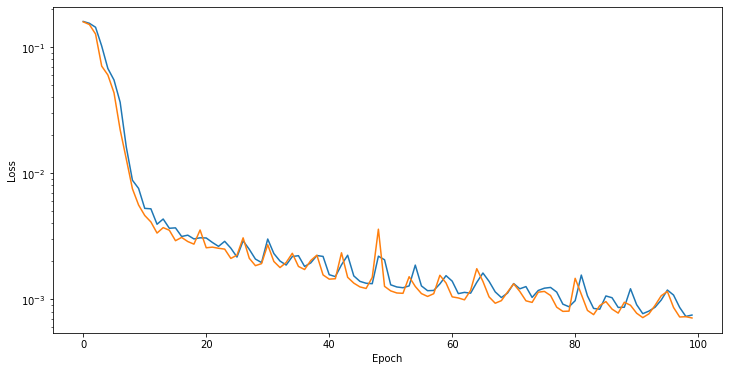

In [9]:
print(history.history.keys())
plt.figure(figsize=(12,6))
plt.semilogy(history.history["loss"])
plt.semilogy(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Wyniki

In [10]:
Y_pred= model.predict(X_val)

#### Przykładowy wynik

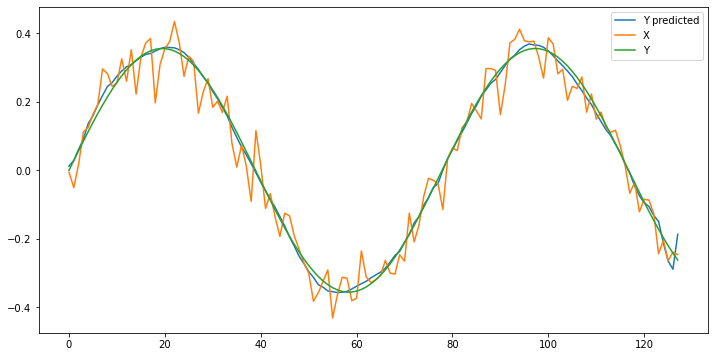

In [11]:
no_sample= 0

plt.figure(figsize=(12,6))
plt.plot(Y_pred[no_sample],label="Y predicted")
plt.plot(X_val[no_sample],label="X")
plt.plot(Y_val[no_sample],label="Y")
plt.legend()

## Wczytanie zapisanych wag i przykładowe użycie

In [12]:
model= create_model(input_shape= (None,1))
model.load_weights("weights/deconvnet_weights")
# Poniżej można używać model:

#### Przykładowe dane

In [13]:
x= np.linspace(0,2.*np.pi,128)
Y= 0.2*np.sin(2*np.pi/3*x)
X= Y + np.random.normal(loc=0.0, scale=0.05, size=Y.shape)

#### Użycie sieci na jednym sygnale

Uwaga na wymiary wejściowe tensora z danymi!

In [14]:
Y_pred= model.predict(X[np.newaxis,:])

In [15]:
# Wymiary różnych tensorów:
print(X.shape)
print(Y.shape)
print(Y_pred.shape)

(128,)
(128,)
(1, 128, 1)


#### Wyświetlenie wyniku

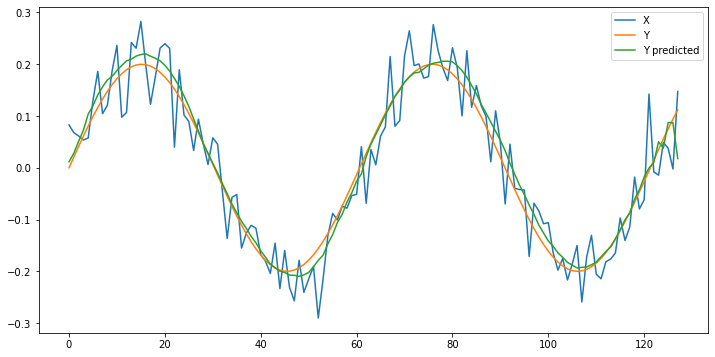

In [16]:
plt.figure(figsize=(12,6))

plt.plot(X,label="X")
plt.plot(Y,label="Y")
plt.plot(Y_pred[0],label="Y predicted")
plt.legend()